<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/stage_2_decision/No_Shows%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from hotel_preprocessing import XYPreprocessor
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna


RANDOM_STATE = 2025
VERBOSE = 2

In [3]:
# === Load data and preprocess arrival date ===
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)
hotel_data['reservation_status_date'] = pd.to_datetime(hotel_data['reservation_status_date'])

# Define target: 1 if No-Show OR cancelled within 3 days before arrival, else 0
hotel_data['days_before_arrival'] = (hotel_data['arrival_date'] - hotel_data['reservation_status_date']).dt.days
hotel_data['late_or_noshow'] = ((hotel_data['reservation_status'] == 'No-Show') |
                                 ((hotel_data['reservation_status'] == 'Canceled') & (hotel_data['days_before_arrival'] <= 3))).astype(int)

# === Filter to only canceled reservations for stage 2 analysis ===
hotel_data = hotel_data[hotel_data['is_canceled'] == 1].reset_index(drop=True)

# === Split train/test by arrival_date ===
last_date = hotel_data['arrival_date'].max()
cutoff_date = last_date - pd.DateOffset(months=3)

test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

cols_to_drop = [
    'reservation_status', 'reservation_status_date', 'arrival_date',
    'days_before_arrival', 'is_canceled'
]

X_train_val_raw = train_val_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_train_val_raw = train_val_data['late_or_noshow']

X_test_raw = test_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_test_raw = test_data['late_or_noshow']

# === Preprocess ===
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

## Decision Tree Classifier

In [4]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),  # allow deeper trees
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # prevent overfitting
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),    # prevent small noisy leaves
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # fine pruning range, log scale
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)

    return np.mean(aucs)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # increase trials for better coverage

print("Best hyperparameters:", study.best_params)

[I 2025-06-18 01:26:56,627] A new study created in memory with name: no-name-ff749ec7-74fd-47b2-bafe-42bcd6b02146
[I 2025-06-18 01:26:59,354] Trial 0 finished with value: 0.7592596194525395 and parameters: {'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 5, 'ccp_alpha': 0.004492230306209153}. Best is trial 0 with value: 0.7592596194525395.
[I 2025-06-18 01:27:01,359] Trial 1 finished with value: 0.8466100815423188 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'ccp_alpha': 0.0001239241527379345}. Best is trial 1 with value: 0.8466100815423188.
[I 2025-06-18 01:27:03,624] Trial 2 finished with value: 0.6794194851500851 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 6, 'ccp_alpha': 0.01217071457099943}. Best is trial 1 with value: 0.8466100815423188.
[I 2025-06-18 01:27:04,412] Trial 3 finished with value: 0.7678225483025388 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 10, 'ccp_a

Best hyperparameters: {'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'ccp_alpha': 0.00016016393380023574}


In [6]:
# Final training on full training + validation data
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_train_val, y_train_val)

# Predict on test set (probabilities and binary class)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)  # threshold at 0.5

# Compute metrics
test_auc = roc_auc_score(y_test, y_test_proba)

print("Final Test AUC:", test_auc)


Final Test AUC: 0.8417896026770986


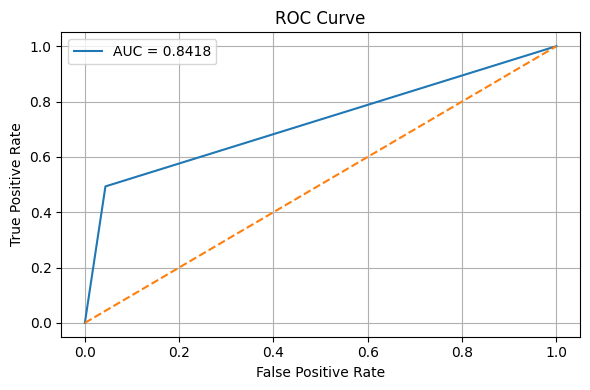

In [10]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

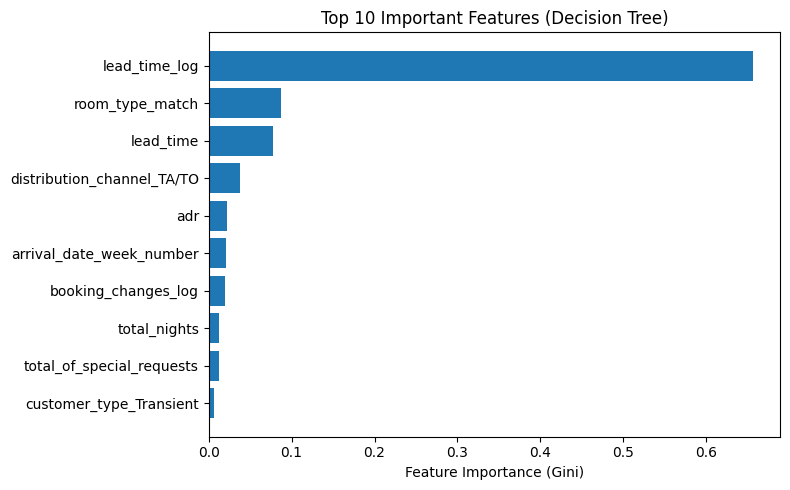

In [11]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train_val.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


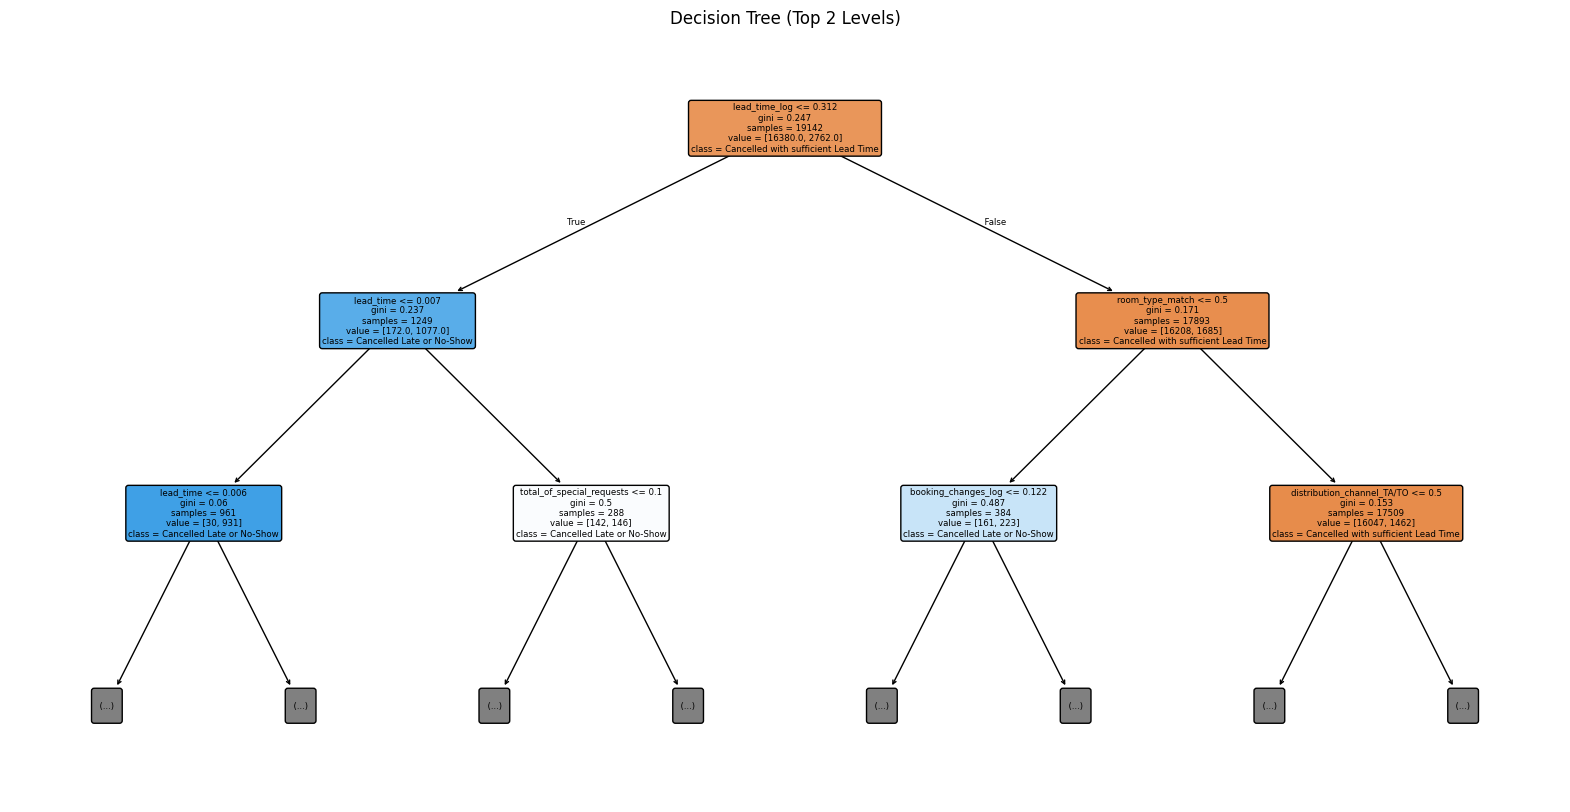

In [15]:
# Visualize the tree
levels_for_viz = 2
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train_val.columns, class_names=["Cancelled with sufficient Lead Time", "Cancelled Late or No-Show"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

## XGB Classifier

In [16]:
# === Optuna objective ===
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'scale_pos_weight': (y_train_val == 0).sum() / (y_train_val == 1).sum(),
        'eval_metric': 'auc',
        'random_state': 42
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in kf.split(X_train_val, y_train_val):
        X_tr = X_train_val.iloc[train_idx].reset_index(drop=True)
        y_tr = y_train_val.iloc[train_idx].reset_index(drop=True)
        X_val = X_train_val.iloc[val_idx].reset_index(drop=True)
        y_val = y_train_val.iloc[val_idx].reset_index(drop=True)

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(val_auc)

    return np.mean(aucs)

# === Run Optuna ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n=== Best Parameters ===")
print(study.best_params)

[I 2025-06-18 01:35:20,399] A new study created in memory with name: no-name-55fc4d9f-40d9-4091-9cb2-828171b9b485
[I 2025-06-18 01:35:34,789] Trial 0 finished with value: 0.8733505476721826 and parameters: {'max_depth': 9, 'learning_rate': 0.07898235772898855, 'n_estimators': 437, 'min_child_weight': 9, 'subsample': 0.5649012589769697, 'colsample_bytree': 0.5719028536923236, 'reg_alpha': 4.954881451153993, 'reg_lambda': 1.0309205396530152}. Best is trial 0 with value: 0.8733505476721826.
[I 2025-06-18 01:35:38,674] Trial 1 finished with value: 0.882728107524426 and parameters: {'max_depth': 6, 'learning_rate': 0.06777726922059671, 'n_estimators': 189, 'min_child_weight': 6, 'subsample': 0.6809058183833684, 'colsample_bytree': 0.5279746806534553, 'reg_alpha': 1.4257493639290657, 'reg_lambda': 3.2712243753719417}. Best is trial 1 with value: 0.882728107524426.
[I 2025-06-18 01:35:43,351] Trial 2 finished with value: 0.8770945179246736 and parameters: {'max_depth': 3, 'learning_rate': 0.1


=== Best Parameters ===
{'max_depth': 8, 'learning_rate': 0.011292051268387296, 'n_estimators': 478, 'min_child_weight': 4, 'subsample': 0.7149719904740401, 'colsample_bytree': 0.8483612540537617, 'reg_alpha': 4.9848817991314665, 'reg_lambda': 1.0181797569875155}


In [20]:
THRESHOLD = 0.7

# === Evaluate final model with best params ===
best_params = study.best_params
best_params.update({
    'scale_pos_weight': (y_train_val == 0).sum() / (y_train_val == 1).sum(),
    'eval_metric': 'auc',
    'random_state': 42
})

model = XGBClassifier(**best_params)
model.fit(X_train_val, y_train_val)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= THRESHOLD).astype(int)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nFinal Test ROC AUC: {test_auc:.4f}")

# === Classification report and confusion matrix ===
print(f"\nClassification Report (threshold {THRESHOLD}):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Final Test ROC AUC: 0.8703

Classification Report (threshold 0.7):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4330
           1       0.70      0.53      0.60       294

    accuracy                           0.96      4624
   macro avg       0.83      0.76      0.79      4624
weighted avg       0.95      0.96      0.95      4624


Confusion Matrix:
[[4263   67]
 [ 139  155]]


In [21]:
# === Feature Importances ===
importances = model.feature_importances_
feature_names = X_train_val.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feat_imp_df.head(10))



Top 10 Feature Importances:
                       feature  importance
74         lead_time_bin_short    0.206723
73      lead_time_bin_same_day    0.171449
14             room_type_match    0.079175
31  distribution_channel_TA/TO    0.056819
34     deposit_type_Non Refund    0.039394
10               lead_time_log    0.035292
26    market_segment_Online TA    0.034682
0                    lead_time    0.033880
33     deposit_type_No Deposit    0.018879
58          agent_binned_240.0    0.018486
